In [132]:
# Import Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#modeling tools
import statsmodels.api as sm

import lightgbm as lgb

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, auc, roc_auc_score, roc_curve, log_loss, make_scorer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

%matplotlib inline
plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

pd.set_option('display.min_row', 15)
pd.set_option('display.max_column', 100)
pd.set_option('display.max_colwidth', 300)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
original = pd.read_csv('../data/Collisions.csv')
clean_data = pd.read_pickle('../data/processed/cleaned_data.pkl')

circles = pd.read_csv('../data/Traffic_Circles.csv')

In [134]:
original['INJURED_OHE'] = original['INJURIES'].apply(lambda x: 1 if x > 0 else 0)

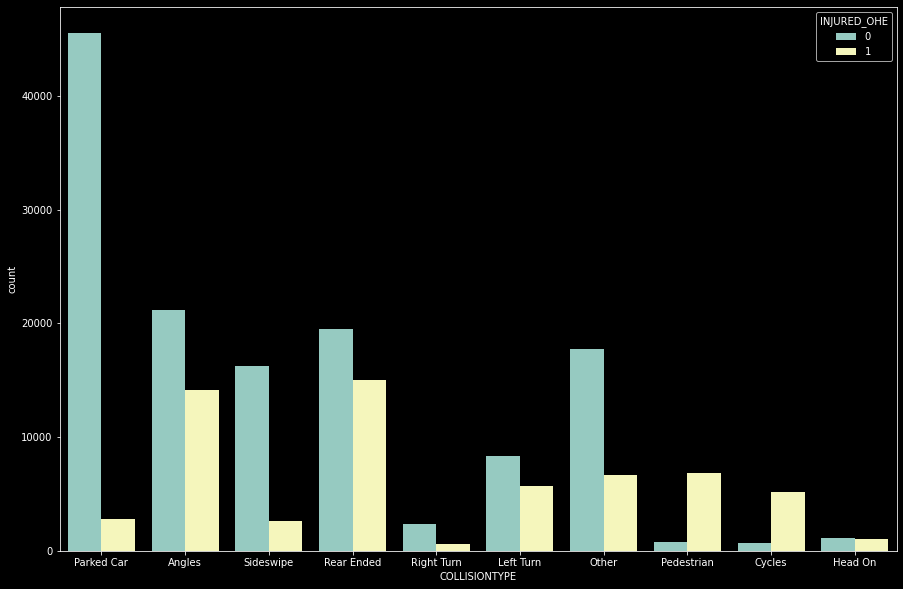

In [135]:
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.countplot('COLLISIONTYPE', data=original, hue='INJURED_OHE');

In [136]:
print( 'Percent not injured: ', round((original['INJURED_OHE'] == 0).sum() / len(original['INJURED_OHE'])*100 , 3) )
print( 'Percent injured: ', round((original['INJURED_OHE'] != 0).sum() / len(original['INJURED_OHE'])*100 , 3) )

Percent not injured:  72.028
Percent injured:  27.972


## Traffic Circles

In [137]:
# no null values
circles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   X                          1066 non-null   float64
 1   Y                          1066 non-null   float64
 2   OBJECTID                   1066 non-null   int64  
 3   COMPKEY                    1066 non-null   int64  
 4   UNITID                     1066 non-null   object 
 5   UNITDESC                   1066 non-null   object 
 6   CONDITION                  1066 non-null   object 
 7   CONDITION_ASSESSMENT_DATE  1066 non-null   object 
 8   CURRENT_STATUS             1066 non-null   object 
 9   OWNERSHIP                  1066 non-null   object 
 10  PRIMARYDISTRICTCD          1066 non-null   object 
 11  SECONDARYDISTRICTCD        1066 non-null   object 
 12  COMPTYPE                   1066 non-null   int64  
 13  CURRENT_STATUS_DATE        1066 non-null   objec

In [138]:
circles.head(2)

,X,Y,OBJECTID,COMPKEY,UNITID,UNITDESC,CONDITION,CONDITION_ASSESSMENT_DATE,CURRENT_STATUS,OWNERSHIP,PRIMARYDISTRICTCD,SECONDARYDISTRICTCD,COMPTYPE,CURRENT_STATUS_DATE,INSTALL_DATE,INSTALL_PURPOSE,INTKEY,LANDSCAPING,MAINTAINED_BY,MAINTENANCE_AGREEMENT,NO_LAND_REASON,OVERRIDECOMMENT,OVERRIDEYN,OWNERSHIP_DATE,SDOT_INITIATED,SEWER_ACCESS_COVER,TRCSIZE,SURVEY_MONUMENT,TRCSHAPE,UNITTYPE,SHAPE_LNG,SHAPE_LAT
0,1.258588e+06,210475.502412,1,509338,TRC-601,38TH AVE SW AND SW DAKOTA ST,GOOD,2009/09/15 00:00:00+00,INSVC,SDOT,DISTRICT1,,16,2009/10/14 00:00:00+00,2000/05/16 00:00:00+00,,31889,Y,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.380088,47.566489
1,1.266983e+06,260074.185342,2,509566,TRC-934,FREMONT AVE N AND N 102ND ST,GOOD,2009/09/09 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1996/01/02 00:00:00+00,,37392,Y,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.350050,47.702894


In [139]:
circles.columns = circles.columns.map(str.lower)

In [140]:
# collisions that happened at a traffic circle: 1449
# some traffic circles had more, so about 593 traffic circles make up the 1613 accidents

circle_accidents = clean_data[clean_data['INTKEY'].isin(circles['intkey'])].copy()

## Choose columns to merge

In [141]:
circle_accidents.columns = circle_accidents.columns.map(str.lower)

In [142]:
# reset index to extract year
circle_accidents.reset_index(inplace=True)
circle_accidents['year'] = circle_accidents['Datetime'].apply(lambda x: x.year)
circle_accidents['month'] = circle_accidents['Datetime'].apply(lambda x: x.month)
circle_accidents['hour'] = circle_accidents['Datetime'].apply(lambda x: x.hour)

In [143]:
circle_accidents.head(2)

,Datetime,x,y,objectid,inckey,addrtype,intkey,location,personcount,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,incdate,junctiontype,sdot_colcode,underinfl,st_colcode,crosswalkkey,speeding_y,inattentionind_y,hitparkedcar_y,pedrownotgrnt_y,weather_adverse,weather_good,weather_unknown,roadcond_adverse,roadcond_dry,roadcond_unknown,lightcond_dark,lightcond_daylight,lightcond_unknown,lightcond_verydark,severitycode_injury,severitycode_propertydamage,severitycode_unknown,year,month,hour
0,2004-01-12 08:45:00,-122.309516,47.699413,9071,21958,Intersection,37717.0,17TH AVE NE AND NE 97TH ST,2,0,1,1,1,0,0,2004/01/12 00:00:00+00,At Intersection (intersection related),18.0,0,45,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,2004,1,8
1,2004-01-16 15:07:00,-122.325306,47.621986,10786,24043,Intersection,29140.0,SUMMIT AVE E AND E HARRISON ST,4,0,0,2,2,0,0,2004/01/16 00:00:00+00,At Intersection (intersection related),11.0,0,10,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,2004,1,15


In [144]:
circle_accidents['crosswalkkey'].value_counts()

0         1436
24378        1
24165        1
24099        1
699870       1
36098        1
25798        1
29890        1
27838        1
525246       1
37441        1
27088        1
29008        1
32855        1
Name: crosswalkkey, dtype: int64

In [145]:
circle_accidents.columns

Index(['Datetime', 'x', 'y', 'objectid', 'inckey', 'addrtype', 'intkey',
       'location', 'personcount', 'pedcount', 'pedcylcount', 'vehcount',
       'injuries', 'seriousinjuries', 'fatalities', 'incdate', 'junctiontype',
       'sdot_colcode', 'underinfl', 'st_colcode', 'crosswalkkey', 'speeding_y',
       'inattentionind_y', 'hitparkedcar_y', 'pedrownotgrnt_y',
       'weather_adverse', 'weather_good', 'weather_unknown',
       'roadcond_adverse', 'roadcond_dry', 'roadcond_unknown',
       'lightcond_dark', 'lightcond_daylight', 'lightcond_unknown',
       'lightcond_verydark', 'severitycode_injury',
       'severitycode_propertydamage', 'severitycode_unknown', 'year', 'month',
       'hour'],
      dtype='object')

In [146]:
'''
KEEP COLUMNS: [['intkey', 'year', 'month', 'hour', 'pedcount', 'pedcylcount', 
'vehcount', 'injuries', 'seriousinjuries', 'fatalities', 'inattentionind_y']]
'''

temp = circle_accidents[['intkey', 'year', 'month', 'hour', 'pedcount', 'pedcylcount', 'vehcount', 
                         'injuries', 'seriousinjuries', 'fatalities', 'inattentionind_y']].copy()

In [147]:
# group by intkey and year to keep accidents that happen at intersections each year
# index is reset to be about to use intkey to merge

circle_acc = temp.groupby(['intkey', 'year', 'month', 'hour']).sum().reset_index()
circle_acc.head()

,intkey,year,month,hour,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,inattentionind_y
0,23843.0,2006,9,16,0,0,2,0,0,0,0
1,23843.0,2009,5,9,0,1,1,1,0,0,0
2,23843.0,2009,12,0,0,0,2,0,0,0,0
3,23862.0,2012,4,13,0,0,2,0,0,0,1
4,23889.0,2009,8,3,0,0,2,0,0,0,0


In [148]:
circle_acc.shape

(1443, 11)

In [149]:
# merge collisions data with circles_acc to obtain dataset of all circles with labels of collisions or none

circles_collisions = circles.merge(circle_acc, how='left', on='intkey')

In [150]:
# intkey has duplicates for the different years

circles_collisions[circles_collisions['intkey'] == 36723]

,x,y,objectid,compkey,unitid,unitdesc,condition,condition_assessment_date,current_status,ownership,primarydistrictcd,secondarydistrictcd,comptype,current_status_date,install_date,install_purpose,intkey,landscaping,maintained_by,maintenance_agreement,no_land_reason,overridecomment,overrideyn,ownership_date,sdot_initiated,sewer_access_cover,trcsize,survey_monument,trcshape,unittype,shape_lng,shape_lat,year,month,hour,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,inattentionind_y
308,1.276636e+06,263925.690434,166,509817,TRC-203,16TH AVE NE AND NE 117TH ST,GOOD,2009/09/14 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1997/09/19 00:00:00+00,,36723,N,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.311155,47.713966,2007.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
309,1.276636e+06,263925.690434,166,509817,TRC-203,16TH AVE NE AND NE 117TH ST,GOOD,2009/09/14 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1997/09/19 00:00:00+00,,36723,N,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.311155,47.713966,2009.0,8.0,20.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
310,1.276636e+06,263925.690434,166,509817,TRC-203,16TH AVE NE AND NE 117TH ST,GOOD,2009/09/14 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1997/09/19 00:00:00+00,,36723,N,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.311155,47.713966,2014.0,8.0,17.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0
311,1.276636e+06,263925.690434,166,509817,TRC-203,16TH AVE NE AND NE 117TH ST,GOOD,2009/09/14 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1997/09/19 00:00:00+00,,36723,N,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.311155,47.713966,2017.0,9.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
312,1.276636e+06,263925.690434,167,509818,TRC-202,16TH AVE NE AND NE 117TH ST,GOOD,2009/07/06 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1983/07/15 00:00:00+00,,36723,Y,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.311155,47.713966,2007.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
313,1.276636e+06,263925.690434,167,509818,TRC-202,16TH AVE NE AND NE 117TH ST,GOOD,2009/07/06 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1983/07/15 00:00:00+00,,36723,Y,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.311155,47.713966,2009.0,8.0,20.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
314,1.276636e+06,263925.690434,167,509818,TRC-202,16TH AVE NE AND NE 117TH ST,GOOD,2009/07/06 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1983/07/15 00:00:00+00,,36723,Y,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.311155,47.713966,2014.0,8.0,17.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0
315,1.276636e+06,263925.690434,167,509818,TRC-202,16TH AVE NE AND NE 117TH ST,GOOD,2009/07/06 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1983/07/15 00:00:00+00,,36723,Y,SDOT,NaN,,NaN,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.311155,47.713966,2017.0,9.0,20.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [152]:
# about 76.06% of traffic circles that had collisions resulted in an injury

print('Percent of traffic circles with incidents: ',
      round((~circles_collisions['year'].isnull()).sum() / (len(circles_collisions['year']))*100 , 2),'%')

Percent of traffic circles with incidents:  76.06 %


In [128]:
circles_collisions.isnull().sum()

x                               0
y                               0
objectid                        0
compkey                         0
unitid                          0
unitdesc                        0
condition                       0
condition_assessment_date       0
current_status                  0
ownership                       0
primarydistrictcd               0
secondarydistrictcd             0
comptype                        0
current_status_date             0
install_date                    0
install_purpose                 0
intkey                          0
landscaping                     0
maintained_by                   0
maintenance_agreement        1951
no_land_reason                  0
overridecomment              1951
overrideyn                      0
ownership_date                  0
sdot_initiated                  0
sewer_access_cover              0
trcsize                         0
survey_monument                 0
trcshape                        0
unittype      

In [129]:
# Drop the columns with all missing values and fill collisions information with 0 for not having collisions
# decide what to do with year

# fill_cols = [['pedcount', 'pedcylcount', 'vehcount', 'injuries',
#               'seriousinjuries', 'fatalities', 'inattentionind_y']]

circles_collisions.fillna('0', inplace=True, axis=1)
circles_collisions.drop(columns=['maintenance_agreement', 'overridecomment'], inplace=True)

In [130]:
circles_collisions.isnull().sum()

x                            0
y                            0
objectid                     0
compkey                      0
unitid                       0
unitdesc                     0
condition                    0
condition_assessment_date    0
current_status               0
ownership                    0
primarydistrictcd            0
secondarydistrictcd          0
comptype                     0
current_status_date          0
install_date                 0
install_purpose              0
intkey                       0
landscaping                  0
maintained_by                0
no_land_reason               0
overrideyn                   0
ownership_date               0
sdot_initiated               0
sewer_access_cover           0
trcsize                      0
survey_monument              0
trcshape                     0
unittype                     0
shape_lng                    0
shape_lat                    0
year                         0
month                        0
hour    

## EDA and OHE

In [71]:
circles_collisions.head()

,x,y,objectid,compkey,unitid,unitdesc,condition,condition_assessment_date,current_status,ownership,primarydistrictcd,secondarydistrictcd,comptype,current_status_date,install_date,install_purpose,intkey,landscaping,maintained_by,no_land_reason,overrideyn,ownership_date,sdot_initiated,sewer_access_cover,trcsize,survey_monument,trcshape,unittype,shape_lng,shape_lat,year,month,hour,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,inattentionind_y
0,1.258588e+06,210475.502412,1,509338,TRC-601,38TH AVE SW AND SW DAKOTA ST,GOOD,2009/09/15 00:00:00+00,INSVC,SDOT,DISTRICT1,,16,2009/10/14 00:00:00+00,2000/05/16 00:00:00+00,,31889,Y,SDOT,,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.380088,47.566489,2006,4,0,0,0,1,0,0,0,0
1,1.258588e+06,210475.502412,1,509338,TRC-601,38TH AVE SW AND SW DAKOTA ST,GOOD,2009/09/15 00:00:00+00,INSVC,SDOT,DISTRICT1,,16,2009/10/14 00:00:00+00,2000/05/16 00:00:00+00,,31889,Y,SDOT,,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.380088,47.566489,2017,3,13,0,0,2,1,0,0,0
2,1.266983e+06,260074.185342,2,509566,TRC-934,FREMONT AVE N AND N 102ND ST,GOOD,2009/09/09 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1996/01/02 00:00:00+00,,37392,Y,SDOT,,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.350050,47.702894,2005,5,0,0,1,1,1,0,0,0
3,1.266983e+06,260074.185342,2,509566,TRC-934,FREMONT AVE N AND N 102ND ST,GOOD,2009/09/09 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1996/01/02 00:00:00+00,,37392,Y,SDOT,,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.350050,47.702894,2006,9,9,0,0,2,0,0,0,0
4,1.266983e+06,260074.185342,2,509566,TRC-934,FREMONT AVE N AND N 102ND ST,GOOD,2009/09/09 00:00:00+00,INSVC,SDOT,DISTRICT5,,16,2009/10/14 00:00:00+00,1996/01/02 00:00:00+00,,37392,Y,SDOT,,N,1970/01/01 00:00:00+00,N,N,0,N,CRC,TRC,-122.350050,47.702894,2011,4,8,0,1,1,1,0,0,0


- X and Y is not the actual coordinates. *drop*
- OBJECTID not needed, there are 2 other unique identifiers. *drop*
- COMPKEY is all unique. could be different matches than INTKEY
- UNITID is simply another identifier. *drop*
- CONDITION has 4 values, one is nothing, check those 2 row out.
- CONDITION_ASSESSMENT_DATE can be dropped since there is another. *drop*
- CURRENT_STATUS and OWNERSHIP can be dropped, only one value. *drop*
- PRIMARYDISTRICTCD can be OHE, could be useful for separating by area
- SECONDARYDISTRICTCD can be dropped, basically all missing. *drop*
- COMPTYPE can be dropped, all the same. intersections have different types? circles is 16? *drop*
- CURRENT_STATUS_DATE mainly same year, not useful. drop
- INSTALL_DATE can be taken for its year just to see how many are built and when
- INSTALL_PURPOSE has way too much missing. however, check out rows with 'SAFETY'
    - all with 'SAFETY' and 'CALMING' has basically all had accidents. But then again, most traffic circles do (about 56%)
- INTKEY needs for merging with intersections
- LANDSCAPING, SDOT_INITIATED, SEWER_ACCESS_COVER, TRCSIZE, SURVEY_MONUMENT is very imbalanced but has only 2 values
    - SDOT_INITIATED and SEWER_ACCESS_COVER can be dropped
    - deeper look into LANDSCAPING, TRCSIZE and SURVEY_MONUMENT before dropping
- MAINTAINED_BY, NO_LAND_REASON, OVERRIDEYN, OWNERSHIP_DATE *drop*
- TRCSHAPE has 4 values, 1 empty. can make into circle vs non-circle
- UNITTYPE only 1 value. *drop*
- SHAPE_LNG and SHAPE_LAT can be used for very precise merging

In [72]:
to_drop = ['x', 'y', 'objectid', 'unitid', 'current_status_date', 'condition_assessment_date', 'current_status', 'ownership', 
           'secondarydistrictcd', 'comptype', 'install_purpose', 'sdot_initiated', 'sewer_access_cover', 
           'maintained_by', 'no_land_reason', 'overrideyn', 'ownership_date', 'unittype']

In [73]:
circles_collisions.drop(columns=to_drop, inplace=True)

In [74]:
circles_collisions.head(2)

,compkey,unitdesc,condition,primarydistrictcd,install_date,intkey,landscaping,trcsize,survey_monument,trcshape,shape_lng,shape_lat,year,month,hour,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,inattentionind_y
0,509338,38TH AVE SW AND SW DAKOTA ST,GOOD,DISTRICT1,2000/05/16 00:00:00+00,31889,Y,0,N,CRC,-122.380088,47.566489,2006,4,0,0,0,1,0,0,0,0
1,509338,38TH AVE SW AND SW DAKOTA ST,GOOD,DISTRICT1,2000/05/16 00:00:00+00,31889,Y,0,N,CRC,-122.380088,47.566489,2017,3,13,0,0,2,1,0,0,0


### Extract dates

In [75]:
# change to datetime first for easy extraction
circles_collisions['install_date'] = circles_collisions['install_date'].apply(pd.to_datetime)

In [76]:
# a lot of them installed in different years. could be useful. keep.

circles_collisions['install_date'].apply(lambda x: x.year).value_counts()

1970    505
1997    115
1983    107
1993    105
1999    101
1994     74
1991     73
1998     68
1996     67
1984     64
2000     58
1995     53
1990     50
1985     49
1982     48
1992     47
1989     41
2003     40
1981     39
2001     30
1987     30
1986     29
2002     26
2018     24
1980     23
2009     21
2005     19
1988     12
2010     12
1979      9
2004      4
2015      3
2006      2
1978      1
1976      1
2007      1
Name: install_date, dtype: int64

In [77]:
circles_collisions['installed'] = circles_collisions['install_date'].apply(lambda x: x.year)

In [78]:
# drop the install_date and current_status_date column

circles_collisions.drop(columns=['install_date'], inplace=True)

In [79]:
circles_collisions.head(2)

,compkey,unitdesc,condition,primarydistrictcd,intkey,landscaping,trcsize,survey_monument,trcshape,shape_lng,shape_lat,year,month,hour,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,inattentionind_y,installed
0,509338,38TH AVE SW AND SW DAKOTA ST,GOOD,DISTRICT1,31889,Y,0,N,CRC,-122.380088,47.566489,2006,4,0,0,0,1,0,0,0,0,2000
1,509338,38TH AVE SW AND SW DAKOTA ST,GOOD,DISTRICT1,31889,Y,0,N,CRC,-122.380088,47.566489,2017,3,13,0,0,2,1,0,0,0,2000


### Encode binary columns

In [80]:
circles_collisions[['landscaping', 'survey_monument']] = (circles_collisions[['landscaping', 'survey_monument']] == 'Y').astype(int)

### Check column with empty value (but not NaN)

In [81]:
circles_collisions[circles_collisions['trcshape'] == ' ']

,compkey,unitdesc,condition,primarydistrictcd,intkey,landscaping,trcsize,survey_monument,trcshape,shape_lng,shape_lat,year,month,hour,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,inattentionind_y,installed
348,579134,PHINNEY AVE N AND N 115TH ST,GOOD,DISTRICT5,36387,0,10,0,,-122.354183,47.712342,2009,11,22,0,0,2,0,0,0,0,1970
349,579134,PHINNEY AVE N AND N 115TH ST,GOOD,DISTRICT5,36387,0,10,0,,-122.354183,47.712342,2010,2,9,0,0,2,1,0,0,0,1970
739,505456,PALATINE AVE N AND N 117TH ST,GOOD,DISTRICT5,36231,1,16,0,,-122.356859,47.714164,2006,2,0,0,0,2,0,0,0,0,2009
740,505456,PALATINE AVE N AND N 117TH ST,GOOD,DISTRICT5,36231,1,16,0,,-122.356859,47.714164,2006,7,9,0,0,2,0,0,0,0,2009
741,505456,PALATINE AVE N AND N 117TH ST,GOOD,DISTRICT5,36231,1,16,0,,-122.356859,47.714164,2007,9,0,0,0,2,0,0,0,0,2009


In [82]:
# can fill trcshape based on majority shape built in same year
# in 1970, most are circles
# in 2009, most are circles but can check by district. most are circles in 2009, district 5

circles_collisions['trcshape'] = circles_collisions['trcshape'].apply(lambda x: 'CRC' if x == ' ' else x)

In [83]:
circles_collisions['trcshape'].value_counts()

CRC      1607
OVAL      255
OTHER      89
Name: trcshape, dtype: int64

In [84]:
circles_collisions[circles_collisions['condition'] == ' '].head()

,compkey,unitdesc,condition,primarydistrictcd,intkey,landscaping,trcsize,survey_monument,trcshape,shape_lng,shape_lat,year,month,hour,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,inattentionind_y,installed
794,646852,29TH AVE SW AND SW HENDERSON ST,,DISTRICT1,34944,0,26,1,OVAL,-122.369941,47.522856,2005,5,0,0,0,2,3,0,0,0,1970
795,646852,29TH AVE SW AND SW HENDERSON ST,,DISTRICT1,34944,0,26,1,OVAL,-122.369941,47.522856,2006,2,0,0,0,2,0,0,0,0,1970
796,646852,29TH AVE SW AND SW HENDERSON ST,,DISTRICT1,34944,0,26,1,OVAL,-122.369941,47.522856,2007,3,15,0,0,2,1,0,0,0,1970
797,646852,29TH AVE SW AND SW HENDERSON ST,,DISTRICT1,34944,0,26,1,OVAL,-122.369941,47.522856,2009,4,9,0,0,2,2,0,0,0,1970
798,646852,29TH AVE SW AND SW HENDERSON ST,,DISTRICT1,34944,0,26,1,OVAL,-122.369941,47.522856,2010,1,14,0,0,2,2,0,0,0,1970


In [85]:
# can fill condition based on majority checked in year and installed in same year
# all district installed and current_status_date in 1970 is in good condition

circles_collisions['condition'] = circles_collisions['condition'].apply(lambda x: 'GOOD' if x == ' ' else x)

In [86]:
circles_collisions['condition'].value_counts()

GOOD    1886
FAIR      63
POOR       2
Name: condition, dtype: int64

In [87]:
circles_collisions.columns

Index(['compkey', 'unitdesc', 'condition', 'primarydistrictcd', 'intkey',
       'landscaping', 'trcsize', 'survey_monument', 'trcshape', 'shape_lng',
       'shape_lat', 'year', 'month', 'hour', 'pedcount', 'pedcylcount',
       'vehcount', 'injuries', 'seriousinjuries', 'fatalities',
       'inattentionind_y', 'installed'],
      dtype='object')

In [88]:
# reorder columns
# decided to not keep compkey

circles_collisions = circles_collisions[['intkey', 'shape_lat', 'shape_lng', 'unitdesc','primarydistrictcd',  
                                         'installed', 'landscaping', 'survey_monument', 'trcsize', 'trcshape', 
                                         'condition','year', 'month', 'hour', 'pedcount', 'pedcylcount', 
                                         'vehcount', 'injuries','seriousinjuries', 'fatalities', 
                                         'inattentionind_y']]

In [91]:
circles_collisions.groupby('intkey').count()

,shape_lat,shape_lng,unitdesc,primarydistrictcd,installed,landscaping,survey_monument,trcsize,trcshape,condition,year,month,hour,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,inattentionind_y
intkey,,,,,,,,,,,,,,,,,,,,
23843,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
23862,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
23866,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
23867,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
23868,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
23869,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
23886,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37969,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [97]:
# circles_collisions.to_csv('../data/processed/circles_collisions.csv')

## EDA: Useful Columns

In [98]:
# decide which columns aren't useful

circles_collisions.columns

Index(['intkey', 'shape_lat', 'shape_lng', 'unitdesc', 'primarydistrictcd',
       'installed', 'landscaping', 'survey_monument', 'trcsize', 'trcshape',
       'condition', 'year', 'month', 'hour', 'pedcount', 'pedcylcount',
       'vehcount', 'injuries', 'seriousinjuries', 'fatalities',
       'inattentionind_y'],
      dtype='object')

In [99]:
circles_collisions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1951 entries, 0 to 1950
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   intkey             1951 non-null   int64  
 1   shape_lat          1951 non-null   float64
 2   shape_lng          1951 non-null   float64
 3   unitdesc           1951 non-null   object 
 4   primarydistrictcd  1951 non-null   object 
 5   installed          1951 non-null   int64  
 6   landscaping        1951 non-null   int64  
 7   survey_monument    1951 non-null   int64  
 8   trcsize            1951 non-null   int64  
 9   trcshape           1951 non-null   object 
 10  condition          1951 non-null   object 
 11  year               1951 non-null   object 
 12  month              1951 non-null   object 
 13  hour               1951 non-null   object 
 14  pedcount           1951 non-null   object 
 15  pedcylcount        1951 non-null   object 
 16  vehcount           1951 

Make sure numeric columns are not object type.

In [100]:
numeric_cols = {'year':'int', 'pedcount':'float', 'pedcylcount':'float', 'vehcount':'float', 
                'injuries':'float','seriousinjuries':'float', 'fatalities':'float', 'inattentionind_y':'float'}

circles_collisions = circles_collisions.astype(numeric_cols)

In [101]:
circles_collisions.head()

,intkey,shape_lat,shape_lng,unitdesc,primarydistrictcd,installed,landscaping,survey_monument,trcsize,trcshape,condition,year,month,hour,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,inattentionind_y
0,31889,47.566489,-122.380088,38TH AVE SW AND SW DAKOTA ST,DISTRICT1,2000,1,0,0,CRC,GOOD,2006,4,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,31889,47.566489,-122.380088,38TH AVE SW AND SW DAKOTA ST,DISTRICT1,2000,1,0,0,CRC,GOOD,2017,3,13,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,37392,47.702894,-122.350050,FREMONT AVE N AND N 102ND ST,DISTRICT5,1996,1,0,0,CRC,GOOD,2005,5,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,37392,47.702894,-122.350050,FREMONT AVE N AND N 102ND ST,DISTRICT5,1996,1,0,0,CRC,GOOD,2006,9,9,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,37392,47.702894,-122.350050,FREMONT AVE N AND N 102ND ST,DISTRICT5,1996,1,0,0,CRC,GOOD,2011,4,8,0.0,1.0,1.0,1.0,0.0,0.0,0.0


In [102]:
circles_collisions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1951 entries, 0 to 1950
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   intkey             1951 non-null   int64  
 1   shape_lat          1951 non-null   float64
 2   shape_lng          1951 non-null   float64
 3   unitdesc           1951 non-null   object 
 4   primarydistrictcd  1951 non-null   object 
 5   installed          1951 non-null   int64  
 6   landscaping        1951 non-null   int64  
 7   survey_monument    1951 non-null   int64  
 8   trcsize            1951 non-null   int64  
 9   trcshape           1951 non-null   object 
 10  condition          1951 non-null   object 
 11  year               1951 non-null   int64  
 12  month              1951 non-null   object 
 13  hour               1951 non-null   object 
 14  pedcount           1951 non-null   float64
 15  pedcylcount        1951 non-null   float64
 16  vehcount           1951 

In [103]:
eliminate = ['unitdesc', 'intkey', 'shape_lng', 'shape_lat']

data = circles_collisions.drop(columns=eliminate).copy()

In [104]:
data.head()

,primarydistrictcd,installed,landscaping,survey_monument,trcsize,trcshape,condition,year,month,hour,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,inattentionind_y
0,DISTRICT1,2000,1,0,0,CRC,GOOD,2006,4,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,DISTRICT1,2000,1,0,0,CRC,GOOD,2017,3,13,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,DISTRICT5,1996,1,0,0,CRC,GOOD,2005,5,0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,DISTRICT5,1996,1,0,0,CRC,GOOD,2006,9,9,0.0,0.0,2.0,0.0,0.0,0.0,0.0
4,DISTRICT5,1996,1,0,0,CRC,GOOD,2011,4,8,0.0,1.0,1.0,1.0,0.0,0.0,0.0


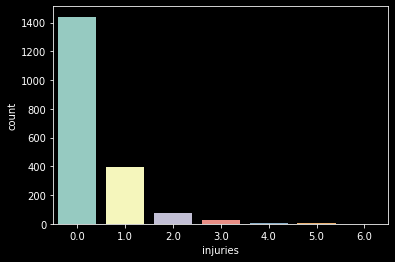

In [105]:
sns.countplot(data['injuries'])

In [106]:
data.groupby('primarydistrictcd').sum()

,installed,landscaping,survey_monument,trcsize,year,pedcount,pedcylcount,vehcount,injuries,seriousinjuries,fatalities,inattentionind_y
primarydistrictcd,,,,,,,,,,,,
DISTRICT1,434409,192,48,911,361773,3.0,5.0,313.0,91.0,3.0,1.0,20.0
DISTRICT2,567803,281,57,2079,494686,6.0,3.0,456.0,118.0,1.0,0.0,27.0
DISTRICT3,776582,387,42,864,631393,22.0,30.0,542.0,132.0,7.0,0.0,35.0
DISTRICT4,402437,198,27,548,227122,6.0,11.0,198.0,50.0,1.0,0.0,16.0
DISTRICT5,825156,339,28,489,649333,6.0,29.0,570.0,154.0,6.0,0.0,34.0
DISTRICT6,713538,349,57,1162,516619,10.0,22.0,438.0,106.0,6.0,0.0,22.0
DISTRICT7,156947,64,29,518,102560,5.0,1.0,94.0,23.0,1.0,0.0,7.0
